<a href="https://colab.research.google.com/github/vitamingyu/NLP-LLM/blob/main/tf_45attention_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 텍스트 요약은 주로 추출적 요약과 추상적 요약으로 나뉨(추상은 원문에 없는 것도)
# 어텐션을 이용한 텍스트 요약(Text Summarization with Attention mechanism)
# 아마존 리뷰 데이터 사용
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

In [2]:
# Reviews.csv 파일을 data라는 이름의 데이터프레임에 저장. 단, 10만개의 행(rows)으로 제한.
data = pd.read_csv("/content/Reviews_short.csv", nrows = 100000)
print('전체 리뷰 개수 :',(len(data)))
data.head()

전체 리뷰 개수 : 10000


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
data = data[['Text','Summary']]
print(data.head())
print(data.sample(10))

print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

# text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['Text'], inplace=True)
print("전체 샘플수 :", len(data))

print(data.isnull().sum())
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))


                                                Text                Summary
0  I have bought several of the Vitality canned d...  Good Quality Dog Food
1  Product arrived labeled as Jumbo Salted Peanut...      Not as Advertised
2  This is a confection that has been around a fe...  "Delight" says it all
3  If you are looking for the secret ingredient i...         Cough Medicine
4  Great taffy at a great price.  There was a wid...            Great taffy
                                                   Text  \
9394  I've read so many reviews on the many brands a...   
898   The product is all that it says it is which is...   
2398  Very Smooth Rich flavor even on the largest se...   
5906  I subscribe to these now & switch around to th...   
2343  My Dogs love this natural kibble.  It's simple...   
8225  I have fed my 2 cats these treats the last 2 d...   
5506  It is great thin and tasty brown rice. Just fo...   
6451  I agree with everything that the previous revi...   
2670  I used 

<ipython-input-3-b63f3fe19b45>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(subset=['Text'], inplace=True)
<ipython-input-3-b63f3fe19b45>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(axis=0, inplace=True)


In [4]:
# 단어 정규화와 불용어 제거를 위해 각각의 참고 자료가 필요합니다. 동일한 의미를 가졌지만 스펠링이 다른 단어들을 정규화하기 위한 사전을 만듭니다.
# 전처리 함수 내 사용

contractions = {"'cause": 'because',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "ain't": 'is not',
 "aren't": 'are not',
 "can't": 'cannot',
 "could've": 'could have',
 "couldn't": 'could not',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'll": 'he will',
 "he's": 'he is',
 "here's": 'here is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "i'd": 'i would',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'll've": 'i will have',
 "i'm": 'i am',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must have',
 "mustn't": 'must not',
 "mustn't've": 'must not have',
 "needn't": 'need not',
 "needn't've": 'need not have',
 "o'clock": 'of the clock',
 "oughtn't": 'ought not',
 "oughtn't've": 'ought not have',
 "sha'n't": 'shall not',
 "shan't": 'shall not',
 "shan't've": 'shall not have',
 "she'd": 'she would',
 "she'd've": 'she would have',
 "she'll": 'she will',
 "she'll've": 'she will have',
 "she's": 'she is',
 "should've": 'should have',
 "shouldn't": 'should not',
 "shouldn't've": 'should not have',
 "so's": 'so as',
 "so've": 'so have',
 "that'd": 'that would',
 "that'd've": 'that would have',
 "that's": 'that is',
 "there'd": 'there would',
 "there'd've": 'there would have',
 "there's": 'there is',
 "they'd": 'they would',
 "they'd've": 'they would have',
 "they'll": 'they will',
 "they'll've": 'they will have',
 "they're": 'they are',
 "they've": 'they have',
 "this's": 'this is',
 "to've": 'to have',
 "wasn't": 'was not',
 "we'd": 'we would',
 "we'd've": 'we would have',
 "we'll": 'we will',
 "we'll've": 'we will have',
 "we're": 'we are',
 "we've": 'we have',
 "weren't": 'were not',
 "what'll": 'what will',
 "what'll've": 'what will have',
 "what're": 'what are',
 "what's": 'what is',
 "what've": 'what have',
 "when's": 'when is',
 "when've": 'when have',
 "where'd": 'where did',
 "where's": 'where is',
 "where've": 'where have',
 "who'll": 'who will',
 "who'll've": 'who will have',
 "who's": 'who is',
 "who've": 'who have',
 "why's": 'why is',
 "why've": 'why have',
 "will've": 'will have',
 "won't": 'will not',
 "won't've": 'will not have',
 "would've": 'would have',
 "wouldn't": 'would not',
 "wouldn't've": 'would not have',
 "y'all": 'you all',
 "y'all'd": 'you all would',
 "y'all'd've": 'you all would have',
 "y'all're": 'you all are',
 "y'all've": 'you all have',
 "you'd": 'you would',
 "you'd've": 'you would have',
 "you'll": 'you will',
 "you'll've": 'you will have',
 "you're": 'you are',
 "you've": 'you have'}


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-6-ab2bf984ff89>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


불용어 개수 : 179
{'at', 'were', 'but', 're', 'these', 'into', 'yourselves', 'or', 'up', 'to', 'don', 'just', 'can', 'my', 'isn', 'and', 'how', 'mustn', 'here', "don't", 'when', 'each', 'out', 'below', 'with', 'very', 'of', "needn't", "should've", 'that', 'll', 'having', 'wouldn', 'd', 'ourselves', 'am', 'is', "you'd", 'your', "you've", 'if', 'same', 'me', 'now', 't', 'over', 'so', 'ain', "isn't", 'you', "didn't", 'on', "weren't", 'had', 'from', 'as', "doesn't", 'them', "you're", 'wasn', 'did', 'her', 'before', 'after', "mustn't", 's', 'myself', 'himself', 'couldn', 'further', 'weren', 'while', 'this', 'theirs', 'needn', 'being', 'who', 'ours', "that'll", 'does', 'not', 'hadn', "won't", 'mightn', 'under', 'it', 'no', 'where', 'haven', 'won', 'she', 'by', 'doesn', "aren't", 'shouldn', 'what', 'shan', 'yourself', 'ma', 'through', 've', 'only', 'there', 'aren', 'any', 'own', 'we', 'itself', "shan't", 'between', 'down', 'until', "couldn't", 'have', 'during', 'has', 'o', 'all', 'whom', 'those', 

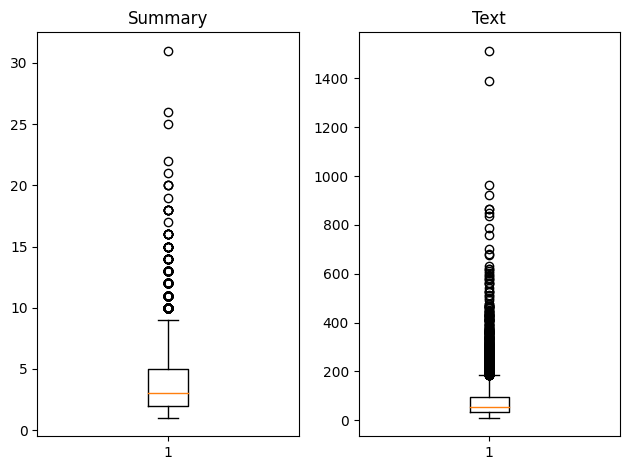

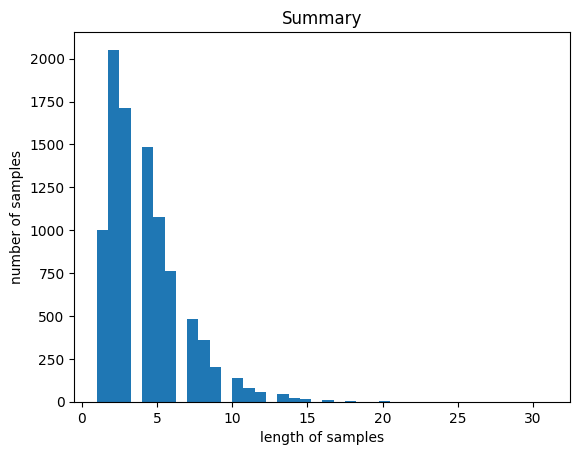

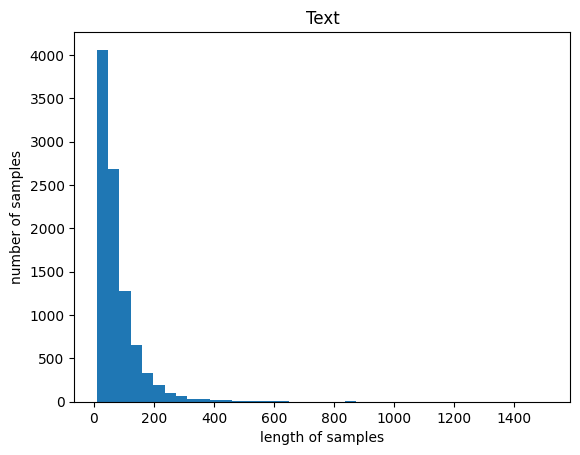

In [6]:
# NLTK의 불용어
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

# Text 열 전처리
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
print(clean_text[:5])

# Summary 열 전처리
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
print(clean_summary[:5])

# 길이가 공백인 샘플은 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [7]:
# 패딩의 길이를 정하겠습니다. 평균 길이보다는 크게 잡아 각각 50과 8로 결정합니다.

text_max_len = 50
summary_max_len = 8

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])

# 정해준 최대 길이보다 큰 샘플들은 제거하겠습니다.
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

print(data.head())

# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

# 인코더의 입력, 디코더의 입력과 레이블을 각각 저장해줍니다.
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.4574792389361926
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9393461578892043
전체 샘플수 : 4229
                                                Text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   
3  If you are looking for the secret ingredient i...   
4  Great taffy at a great price.  There was a wid...   
6  This saltwater taffy had great flavors and was...   

                                         Summary  
0                          Good Quality Dog Food  
1                              Not as Advertised  
3                                 Cough Medicine  
4                                    Great taffy  
6  Great!  Just as good as the expensive brands!  


In [10]:
# 데이터의 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

# 테스트 데이터는 전체 데이터에서 20%에 해당하는 13,163개를 사용하겠습니다.

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

[2756 1613 1748 ... 4134 1574  480]
테스트 데이터의 수 : 845
훈련 데이터의 개수 : 3384
훈련 레이블의 개수 : 3384
테스트 데이터의 개수 : 845
테스트 레이블의 개수 : 845


In [11]:
# 정수 인코딩
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 6876
등장 빈도가 6번 이하인 희귀 단어의 수: 5437
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 1439
단어 집합에서 희귀 단어의 비율: 79.07213496218732
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.104022644385172


In [12]:
# 단어 집합의 크기를 8000으로 제한하겠습니다.

src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
print(encoder_input_train[:3])

#  레이블에 해당하는 요약 데이터에 대해서도 수행하겠습니다.

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


[[44, 160, 7, 1104, 62, 44, 27, 20, 62, 13, 62, 2612, 231, 1, 372, 24, 1301, 6, 740, 62, 21, 27, 104, 7, 305, 22, 19, 441, 1, 62, 27, 306, 449, 210, 1840, 54, 59, 31, 63, 64, 1, 218, 3580], [2, 65, 6, 10, 194, 44, 27, 319, 3, 108, 3, 68, 71, 52, 1, 3581, 33, 19, 1302, 26, 26, 2, 84, 1617, 1, 55, 223, 4, 171, 547, 516, 43, 197, 412, 21, 237, 3582, 90, 198, 1, 3583, 677], [174, 9, 1, 117, 14, 250, 20, 13, 1, 99, 334, 354, 8, 250, 1105, 2, 21, 2149, 373, 11, 307, 257, 186, 7, 101, 5, 469, 2, 74, 5, 502]]
단어 집합(vocabulary)의 크기 : 2204
등장 빈도가 5번 이하인 희귀 단어의 수: 1907
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 297
단어 집합에서 희귀 단어의 비율: 86.52450090744101
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 21.337445675031542


In [13]:
# 등장 빈도가 5회 이하인 단어들은 정수인코딩에서 제외
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print(decoder_input_train[:5])
print(decoder_target_train[:5])

[[1, 222, 255, 4, 938, 25, 74, 116], [1, 358, 939, 78, 299, 940], [1, 11, 42, 4], [1, 65, 941], [1, 3, 90, 25, 602, 435]]
[[222, 255, 4, 938, 25, 74, 116, 2], [358, 939, 78, 299, 940, 2], [11, 42, 4, 2], [65, 941, 2], [3, 90, 25, 602, 435, 2]]


In [14]:
# 빈 샘플(empty samples) 제거
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

# 삭제 후의 개수는 다음과 같습니다.
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

# 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

삭제할 훈련 데이터의 개수 : 17
삭제할 테스트 데이터의 개수 : 24
훈련 데이터의 개수 : 3367
훈련 레이블의 개수 : 3367
테스트 데이터의 개수 : 821
테스트 레이블의 개수 : 821


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [15]:
# seq2seq + attention으로 요약 모델 설계 및 훈련시키기
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더는 3개의 층을 쌓습니다
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# 디코더의 출력층을 설계합니다.

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 128)              1024000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 50, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [17]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/20.%20Text%20Summarization%20with%20Attention/attention.py", filename="attention.py")
from attention import AttentionLayer

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 128)              1024000   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 50, 256),            394240    ['embedding[0][0]']           
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                            

In [18]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
14/14 [==============================] - 28s 644ms/step - loss: 5.0222 - val_loss: 2.8125
Epoch 2/50
14/14 [==============================] - 9s 655ms/step - loss: 3.1056 - val_loss: 2.7166
Epoch 3/50
14/14 [==============================] - 11s 778ms/step - loss: 3.0531 - val_loss: 2.6643
Epoch 4/50
14/14 [==============================] - 15s 1s/step - loss: 3.0064 - val_loss: 2.6427
Epoch 5/50
14/14 [==============================] - 10s 720ms/step - loss: 2.9523 - val_loss: 2.5738
Epoch 6/50
14/14 [==============================] - 9s 651ms/step - loss: 2.8637 - val_loss: 2.4540
Epoch 7/50
14/14 [==============================] - 8s 606ms/step - loss: 2.7852 - val_loss: 2.4010
Epoch 8/50
14/14 [==============================] - 12s 918ms/step - loss: 2.6994 - val_loss: 2.3572
Epoch 9/50
14/14 [==============================] - 12s 827ms/step - loss: 2.6754 - val_loss: 2.3559
Epoch 10/50
14/14 [==============================] - 7s 512ms/step - loss: 2.6315 - val_loss: 2.3

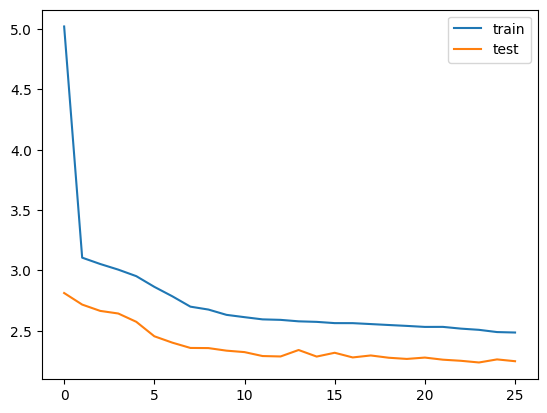

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 테스트를 위해 필요한 3개의 사전을 만듭니다.

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [22]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    sentence=''
    for i in input_seq:
        if(i!=0):
            sentence = sentence + src_index_to_word[i]+' '
    return sentence

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence


In [24]:
for i in range(0, 820):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
원문 :  this has been a christmas favorite since my late sister in law introduced our family to these cookies over 20 years ago she was from italy and loved these cookies as do we 
실제 요약문 : lazzaroni cookies 
1/1 [==============================] - 0s 19ms/step
예측 요약문 :  great product


원문 :  we like this brownie mix and i usually use the low fat recipe on it i also add chocolate chips or something else to it otherwise it ends up a little bit dry br br we still buy this by the case 
실제 요약문 : a better brownie some health 
1/1 [==============================] - 0s 18ms/step
예측 요약문 :  great product


원문 :  i was expecting hard tasteless healthy cookies it is soft a little chewy and yummy very tasty 
실제 요약문 : tastes surprisingly good 
1/1 [==============================] - 0s 22ms/step
예측 요약문 :  great product


원문 :  products are a favorite for my family the breakfast cookie are great for snacks coffee breaks and especially good for traveling br this is a p